In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np
import scanpy.api as sc

/Users/david.fischer/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Generate some data:

In [2]:
from batchglm.api.models.nb_glm import Simulator

sim = Simulator(num_observations=2000, num_features=100)
sim.generate_sample_description(num_batches=0, num_confounders=2)
# sample parameters from positive truncated N(1, 0.1)
mu=1; phi=0.1
sim.generate_params(rand_fn_loc=lambda size: mu + scipy.stats.truncnorm.rvs(-mu / phi, np.infty, scale=phi, size=size))
sim.generate_data()

# count data
X = sim.X
# sample description
sample_description = sim.sample_description

The sample description should be a pandas DataFrame with `num_observations` rows.
Each column should represent a property of the dataset.

The module `batchglm.api.data` contains some helper functions which can be useful to create this sample description:

- `sample_description_from_anndata()`
- `sample_description_from_xarray()`

In [3]:
sample_description.iloc[:10,:]

,condition
observations,
0,0
1,1
2,0
3,1
4,0
5,1
6,0
7,1
8,0


Create anndata object:

In [4]:
adata = sc.AnnData(X=np.asarray(X), obs=sample_description)

From here on, we can treat the anndata object as a container of the count matrix, the sample_description and the gene_names and we only pass adata to the diffxpy functions.

# Run differential expression test:

The t-test checks if two groups of samples differ significantly in one gene.

Therefore, it has to be provided with a parameter `grouping` which specifies the group membership of each sample.
It can be either the name of a column in `sample_description` or a vector of length `num_observations`.


In [5]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy.api as de

test = de.test.t_test(
    data=adata,
    grouping="condition"
)


# Obtaining the results

The p-/q-values can be obtained by calling test.pval / test.qval:

In [9]:
test.qval[:10]

array([4.31027763e-14, 1.81540602e-06, 3.98386742e-06, 0.00000000e+00,
       1.32526614e-01, 3.28690940e-01, 7.09680831e-03, 1.11022302e-14,
       0.00000000e+00, 7.68748608e-03])

test.summary() returns a pandas DataFrame with a quick overview of the test results:

In [7]:
test.summary().iloc[:10,:]

,gene,pval,qval,log2fc,zero_mean,zero_variance
0,0,7.327472e-15,4.310278e-14,-0.168075,False,False
1,1,6.172380e-07,1.815406e-06,-0.148008,False,False
2,2,1.434192e-06,3.983867e-06,-0.140714,False,False
3,3,0.000000e+00,0.000000e+00,-0.214080,False,False
4,4,9.818990e-02,1.325266e-01,0.038316,False,False
5,5,2.662397e-01,3.286909e-01,0.025846,False,False
6,6,4.258085e-03,7.096808e-03,0.059529,False,False
7,7,1.776357e-15,1.110223e-14,0.180448,False,False
8,8,0.000000e+00,0.000000e+00,-0.276266,False,False
9,9,4.689367e-03,7.687486e-03,0.157194,False,False


- `gene`: gene name / identifier
- `pval`: p-value of the gene
- `qval`: multiple testing - corrected p-value of the gene
- `log2fc`: log_2 fold change between `no coefficient` and `coefficient`

`test.plot_volcano()` creates a volcano plot of p-values vs. fold-change:

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c298a3908>)

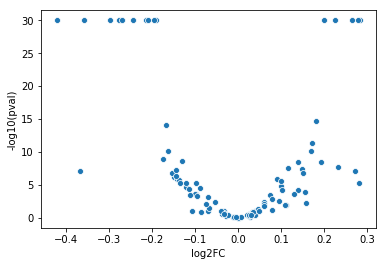

In [8]:
test.plot_volcano()